# Method 1: Using Pystan

I'll do this for a single n, and treat the mode locations as fixed for now.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import corner
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20)


#The stellar parameters are for 16 Cyg A
nus = 0.411 #uHz
i = np.deg2rad(56.) #rad
d02 = 6.8 #uHz
dnu = 102. #uHz

In [7]:
locs = np.genfromtxt('locs.txt')
l0 = locs[int(np.floor(len(locs)/2)), 0]
l1 = locs[int(np.floor(len(locs)/2)), 1]
l2 = locs[int(np.floor(len(locs)/2)-1), 2]
l3 = locs[int(np.floor(len(locs)/2)-1), 3]
ff = np.genfromtxt('freqs.txt')
pp = np.genfromtxt('model.txt')

In [8]:
sel = [(ff >= l0 - 0.3*dnu) & (ff <= l0 + 0.7*dnu)]
f = ff[tuple(sel)]
p = pp[tuple(sel)] 

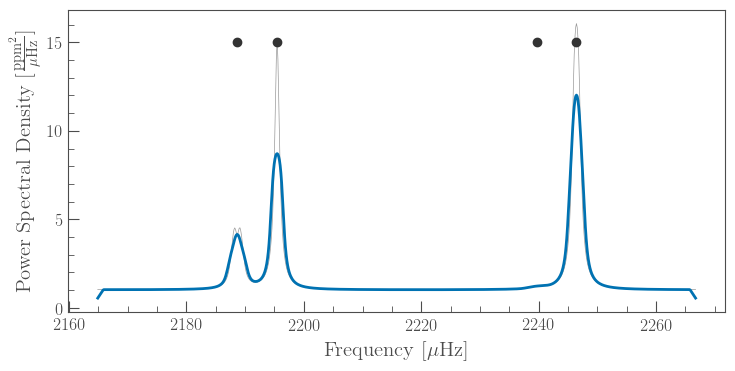

In [10]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5)
pg.smooth(filter_width=2.).plot(ax=ax, linewidth=2)
plt.scatter([l0,l1,l2,l3],[15,15,15,15])

Lets fit a group of lorentzians to these data!

In [17]:
import pystan
model = '''
functions{
    real get_epsilon(real i, int l, int m){  // The solutions to the Legendre Polynomials for mode heights
        if (l == 0){
            return 1.;
        }
        else if (l == 1){
           if (m == 0){
               return cos(i)^2;
           }
           else if (abs(m) == 1){
               return 0.5 * sin(i)^2;
           }
           else return 1.;
        }
        else if (l == 2){
            if (m == 0){
                return 0.25 * (3. * (i)^2 - 1.)^2;
            }
            else if (abs(m) == 1){
                return (3./8.)*sin(2*i)^2;
            }
            else if (abs(m) == 2){
                return (3./8.) * sin(i)^4;
            }
            else return 1.;
        }
        else if (l == 3){
            if (m == 0){
                return (1./64.)*(5.*cos(3.*i) + 3.*cos(i))^2;
            }
            else if (abs(m) == 1){
                return (3./64.)*(5.*cos(2.*i) + 3.)^2 * sin(i)^2;
            }
            else if (abs(m) == 2){
                return (15./8.) * cos(i)^2 * sin(i)^4;
            }
            else if (abs(m) == 3){
                return (5./16.)*sin(i)^6;
            }
            else return 1.;
        }
        else return 1.;
    }
       
    real lorentzian(real loc, int l, int m, real f, real i, real H, real w, real nus){
        return (get_epsilon(i, l, m) * H) ./ (1 + (4/w^2) * (f - loc + m*nus)^2);
    }

    real[] multiplets(int N, real[] locs, real[] f, real i, real[] H, real[] w, real nus){
        real mod[N]; 
        mod = rep_array(1., N);   // Give the model a fixed background of 1.
        
        for (l in 0:3){           // Iterate over all l in a given n
            for (m in -l:l){      // Iterate over all m in a given l
                for (n in 1:N){   // Generate the value of a lorentzian for this l and m at a given f
                    mod[n] += lorentzian(locs[l+1], l, m, f[n], i, H[l+1], w[l+1], nus);
                }
            }
        }
        return mod;
    }
}
data{
    int N;            // Number of data points
    int M;            // Number of modes
    real f[N];        // Frequency
    real p[N];        // Power
    real asy_locs[M]; // Mode locations (this will have to change for multiple n modes)
}
parameters{
    real logAmp[M];      // Mode amplitude in log space
    real logGamma[M];    // Mode linewidth in log space
    real locs[M];        // True mode locations
    real<lower=0> vsini; // Line of sight rotational frequency
    real<lower=0> nus;   // Rotational frequency splitting
}
transformed parameters{
    real i;      // Angle of inclination (rad)
    real H[M];   // Mode height
    real w[M];   // Mode linewidth
     
    i = asin(vsini / nus); // Transform angle of inclination from line of sight rotation frequency
    for (m in 1:M){
        w[m] = 10^logGamma[m];                 // Transform mode linewidth from log space
        H[m] = 10^logAmp[m] / pi() / w[m]; // Transform mode amplitude to mode height
    }
}
model{
    real modes[N];

    modes = multiplets(N, locs, f, i, H, w, nus);
    modes ~ normal(p, 0.1);  // This will eventually have to be expanded to deal with Chi^2dof noise
    
    //priors on the parameters
    logAmp ~ normal(1, 1);
    logGamma ~ normal(0, 0.1);
    locs ~ normal(asy_locs, 1);
    i ~ uniform(0.1, pi()/2);
    nus ~ normal(0.411, 0.1);
}
'''
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d03461b8240504caccc1a65383133f67 NOW.


In [18]:
data = {'N':len(f),
        'M': 4,
        'f':f,
        'p':p,
        'asy_locs':[l0,l1,l2,l3]}

init = {'logAmp' : np.ones(4),
        'logGamma' : np.zeros(4),
        'vsini':nus*np.sin(i),
        'nus':nus,
        'locs' : [l0, l1, l2, l3]}

In [19]:
nchains = 4
fit = sm.sampling(data=data, iter=500, chains=nchains, init = [init for n in range(nchains)])

In [20]:
print(fit)

Inference for Stan model: anon_model_d03461b8240504caccc1a65383133f67.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
logAmp[1]     1.64  5.1e-5 1.8e-3   1.64   1.64   1.64   1.64   1.65   1199    1.0
logAmp[2]     1.81  4.8e-5 1.5e-3   1.81   1.81   1.81   1.82   1.82    932    1.0
logAmp[3]     1.23  2.6e-4 8.9e-3   1.21   1.22   1.23   1.23   1.25   1151    1.0
logAmp[4]    -0.09  5.6e-3   0.11  -0.33  -0.14  -0.08  -0.02   0.08    412    1.0
logGamma[1] 3.7e-4  7.1e-5 2.4e-3-4.2e-3-1.4e-3 3.8e-4 2.1e-3 5.3e-3   1196    1.0
logGamma[2]  -0.01  1.5e-4 4.2e-3  -0.02  -0.01  -0.01-9.0e-3-3.6e-3    773    1.0
logGamma[3] 8.7e-3  6.2e-4   0.02  -0.02-2.7e-3 9.1e-3   0.02   0.04    698    1.0
logGamma[4]   0.02  4.0e-3    0.1  -0.18  -0.04   0.02   0.09    0.2    576    1.0
locs[1]     2195.4  5.3e-5 1.9e-3 2195.4 2195.4 2195.4 2195.4 2195.

/home/oliver/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


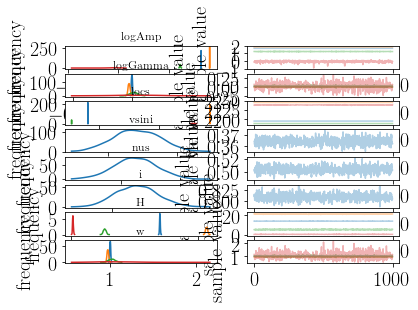

In [21]:
fit.plot()
plt.show()

In [34]:
truths= [init['vsini'],np.nan, np.nan,init['nus']]

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


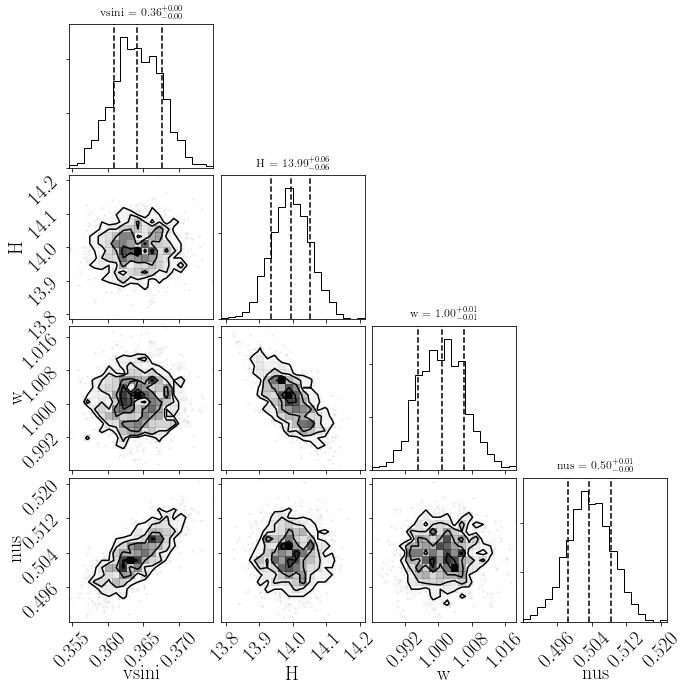

In [35]:
labels=['vsini','H','w','nus']
chain = np.array([fit[labels[0]], fit[labels[1]].T[0], fit[labels[2]].T[0], fit[labels[3]]])
corner.corner(chain.T, labels=labels, quantiles=[0.16, 0.5, 0.84],
            truths=truths,show_titles=True)
plt.show()

In [36]:
init

{'logAmp': array([1., 1., 1., 1.]),
 'logGamma': array([0., 0., 0., 0.]),
 'vsini': 0.3407344423201221,
 'nus': 0.411,
 'locs': [2195.4462474355573,
  2246.4462474355573,
  2188.646247435557,
  2239.646247435557]}